# Demonstration of integrating POI Points to OSM road network
1. Use anyway you like to get the sample [POI data](https://assets.onemap.sg/shp/supermarkets.zip) consisting of supermarkets from [OneMap SG](https://www.onemap.sg/).
2. Use [OSMnx](https://osmnx.readthedocs.io/en/stable/index.html) to download the pedestrian network from [OpenStreetMap](https://openstreetmap.org), we use a bounding box of Toa Payoh for the demo.
3. Save the network as `.shp` and read in as two `GeoDataFrame`s: junction as `nodes` and road segment as `edges`.
4. Integrate POIs into the network using the `connect_poi` function.

In [1]:
!pip3 install wget

In [2]:
import os
import wget
import osmnx as ox
import geopandas as gpd
from toolbox import connect_poi

/Users/itaimondshine/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## 1. Prepare POIs

In [3]:
# get POI data
url = "https://assets.onemap.sg/shp/supermarkets.zip"
PATH = 'data/supermarkets.zip'

if os.path.exists(PATH):
    print('File existed.')
else:
    PATH = wget.download(url, PATH)
    print('File downloaded.')

File existed.


In [4]:
tags = {'amenity': True}

In [5]:
TEL_AVIV_GRAPH = ox.graph.graph_from_place('Tel Aviv, Israel', network_type='all')

In [6]:
poi = ox.geometries.geometries_from_place('Tel Aviv, Israel', tags, which_result=None, buffer_dist=None)

In [7]:
# load and subset the POI based on a bounding box
bbox = (103.8427, 1.3308, 103.8601, 1.3416)  # set bbox of Toa Payoh
pois = gpd.read_file('supermarkets', vfs='zip://{}'.format(PATH), crs='epsg:3857')
pois = pois.to_crs(epsg=4326)
pois['lon'] = pois['geometry'].apply(lambda p: p.x)
pois['lat'] = pois['geometry'].apply(lambda p: p.y)
pois = pois[(pois['lon'] >= bbox[0]) & (pois['lon'] <= bbox[2]) &
            (pois['lat'] >= bbox[1]) & (pois['lat'] <= bbox[3])]
pois['key'] = pois.index  # set a primary key column
pois.head(3)

/Users/itaimondshine/opt/anaconda3/lib/python3.8/site-packages/fiona/env.py:408: FionaDeprecationWarning: The vfs keyword argument is deprecated. Instead, pass a URL that uses a zip or tar (for example) scheme.
  return f(*args, **kwargs)


,LIC_NAME,BLK_HOUSE,STR_NAME,UNIT_NO,POSTCODE,LIC_NO,INC_CRC,FMEL_UPD_D,geometry,lon,lat,key
87,LIN POH LING,212,LORONG 8 TOA PAYOH,43/45,310212,SE06616X000,76E66AB46212193A,2017-11-29,POINT (103.85433 1.34064),103.854334,1.340643,87
116,NTUC FAIRPRICE CO-OPERATIVE LTD,192,LORONG 4 TOA PAYOH,672,310192,S02051L000,BA393865D9429B41,2019-01-24,POINT (103.85048 1.33166),103.850483,1.331662,116
122,NTUC FAIRPRICE CO-OPERATIVE LTD,500,LORONG 6 TOA PAYOH,None,310500,S02103A000,A5C9705C273748FD,2019-01-24,POINT (103.84705 1.33297),103.847050,1.332965,122


In [8]:
pois = poi

In [9]:
pois = pois.reset_index()

In [10]:
pois = pois[pois.element_type == 'node']

[NOTE] For use in pandana, you may want to ensure the key column for the input is numeric-only to avoid processing errors. Preferably use unique integers (int or str) only, and be aware not to intersect with the node key, which is 'osmid' if you use OSM data, in the nodes gdf.

## 2. Prepare network

In [11]:
# get road network and save as .shp
ox.save_graph_shapefile(TEL_AVIV_GRAPH, filepath='data/sample/', encoding='utf-8')

/Users/itaimondshine/opt/anaconda3/lib/python3.8/site-packages/osmnx/io.py:107: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [12]:
# load as GeoDataFrame
nodes = gpd.read_file('data/sample/nodes.shp')
edges = gpd.read_file('data/sample/edges.shp')

In [13]:
pois

,element_type,osmid,amenity,recycling:paper,recycling:plastic_bottles,geometry,brand,brand:wikidata,brand:wikipedia,name,...,roof:levels,roof:material,community_centre,community_centre:for,historic,loc_name,official_name:en,ways,type,name:hi
0,node,271943717,recycling,yes,yes,POINT (34.83273 32.10976),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,318416034,fuel,NaN,NaN,POINT (34.74584 32.03419),Sonol,Q3701622,en:Sonol,סונול,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,331172264,parking,NaN,NaN,POINT (34.77840 32.09561),NaN,NaN,NaN,בני דן,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,331186813,parking,NaN,NaN,POINT (34.78007 32.08998),NaN,NaN,NaN,בזל,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,331195091,fuel,NaN,NaN,POINT (34.79423 32.09672),Paz,Q2211731,en:Paz Oil Company,פז,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,node,10766514004,bench,NaN,NaN,POINT (34.77549 32.06256),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3119,node,10766562105,bicycle_parking,NaN,NaN,POINT (34.77544 32.06255),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3120,node,10766562107,bench,NaN,NaN,POINT (34.77538 32.06252),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3121,node,10766988105,bar,NaN,NaN,POINT (34.77001 32.06157),NaN,NaN,NaN,The Beer Shop,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Integrate POIs and network

In [14]:
# it's a one-liner, but is still at beta at the moment
new_nodes, new_edges = connect_poi(pois, nodes, edges, key_col='osmid', path=None)

/Users/itaimondshine/PycharmProjects/NLP/toolbox/toolbox.py:199: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pois = pois.append(pois, ignore_index=True)
/Users/itaimondshine/PycharmProjects/NLP/toolbox/toolbox.py:200: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pois = pois.append(pois, ignore_index=True)


Building rtree...


/Users/itaimondshine/PycharmProjects/NLP/toolbox/toolbox.py:209: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [Rtree.insert(fid, geom.bounds) for fid, geom in edges_meter['geometry'].iteritems()]


Updating external nodes...
Projecting POIs to the network...


/Users/itaimondshine/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Updating internal nodes...
Updating internal edges...


/Users/itaimondshine/PycharmProjects/NLP/toolbox/toolbox.py:90: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  new_lines = list(split(line, pps))  # split into segments
/Users/itaimondshine/PycharmProjects/NLP/toolbox/toolbox.py:90: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  new_lines = list(split(line, pps))  # split into segments
/Users/itaimondshine/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(


Updating external links...
Remove faulty projections: 92/12492 (0.74%)


/Users/itaimondshine/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(


NOTE: duplication in node coordinates keys
Nodes count: 42935
Node coordinates key count: 26921
Missing 'from' nodes: 0
Missing 'to' nodes: 0


In [65]:
new_edges[new_edges['v'] == 29944865]

,u,v,key,osmid,oneway,name,highway,reversed,length,from,...,lanes,ref,access,tunnel,service,bridge,junction,width,est_width,geometry


In [69]:
new_edges[new_edges['osmid'] == 139699]

,u,v,key,osmid,oneway,name,highway,reversed,length,from,...,lanes,ref,access,tunnel,service,bridge,junction,width,est_width,geometry


In [70]:
new_nodes

,osmid,y,x,highway,street_cou,ref,geometry
osmid,,,,,,,
139693,139693,32.093840,34.790572,traffic_signals,4.0,None,POINT (34.79057 32.09384)
139698,139698,32.093869,34.791231,None,4.0,None,POINT (34.79123 32.09387)
139699,139699,32.095481,34.785571,None,4.0,None,POINT (34.78557 32.09548)
139705,139705,32.095031,34.779959,None,3.0,None,POINT (34.77996 32.09503)
139707,139707,32.095357,34.778492,None,3.0,None,POINT (34.77849 32.09536)
...,...,...,...,...,...,...,...
9990012487,9990012487,32.062419,34.775101,projected_pap,NaN,NaN,POINT (34.77510 32.06242)
9990012488,9990012488,32.062528,34.775448,projected_pap,NaN,NaN,POINT (34.77545 32.06253)
9990012489,9990012489,32.062419,34.775101,projected_pap,NaN,NaN,POINT (34.77510 32.06242)


In [72]:
graph = nx.from_pandas_edgelist(new_edges, 'u', 'v', edge_attr='geometry')
for index, row in new_nodes.iterrows():
    try:
        graph.nodes[row['osmid']]['geometry'] = (row['geometry'].x, row['geometry'].y)
    except:
        print(f"failed: {row['osmid']}")

failed: 29944865
failed: 29944869
failed: 33955874
failed: 35288613
failed: 267818057
failed: 267819097
failed: 282458089
failed: 284880414
failed: 284915964
failed: 286369058
failed: 286643440
failed: 287238001
failed: 287570954
failed: 287572290
failed: 289069615
failed: 289069637
failed: 289069649
failed: 289503065
failed: 290035378
failed: 300129658
failed: 300129665
failed: 311001060
failed: 315468520
failed: 317214411
failed: 318178557
failed: 318186444
failed: 318415053
failed: 318415056
failed: 331994305
failed: 334633502
failed: 334711446
failed: 334719605
failed: 336081749
failed: 338523658
failed: 338523848
failed: 338524366
failed: 339482152
failed: 340368898
failed: 340369251
failed: 340378003
failed: 340423744
failed: 342361863
failed: 343388987
failed: 345342110
failed: 354030217
failed: 354041624
failed: 354047746
failed: 357297508
failed: 357297512
failed: 357531232
failed: 357531339
failed: 357535535
failed: 357535894
failed: 357545243
failed: 358523439
failed: 358530

failed: 2701012456
failed: 2701012461
failed: 2701012465
failed: 2701012471
failed: 2781908889
failed: 2807972448
failed: 2855600801
failed: 2862997451
failed: 2872322307
failed: 2915980262
failed: 2915980279
failed: 2959771672
failed: 2987514843
failed: 2987527145
failed: 2989957353
failed: 3219536978
failed: 3227436731
failed: 3415647934
failed: 3419895561
failed: 3419895570
failed: 3452855004
failed: 3465156314
failed: 3465157315
failed: 3474702893
failed: 3496916396
failed: 3524113301
failed: 3582121002
failed: 3586725515
failed: 3586725558
failed: 3605260302
failed: 3607830168
failed: 3612543566
failed: 3612842299
failed: 3666392253
failed: 3669406136
failed: 3669463359
failed: 3678367014
failed: 3682812196
failed: 3686883540
failed: 3697053928
failed: 3725505598
failed: 3764627640
failed: 3771708547
failed: 3820683117
failed: 3822572290
failed: 3917184870
failed: 3948280837
failed: 3948280840
failed: 3948280842
failed: 3948280843
failed: 3948299399
failed: 3983904257
failed: 3983

failed: 5458635050
failed: 5458635051
failed: 5461682898
failed: 5909805340
failed: 5913117914
failed: 6485685133
failed: 7026268070
failed: 7026304792
failed: 7026304795
failed: 7028507323
failed: 7028507354
failed: 7028507355
failed: 7028507357
failed: 7028507359
failed: 7028507363
failed: 7052025165
failed: 7054485661
failed: 7054485662
failed: 7128806975
failed: 7187251861
failed: 7891472563
failed: 7891472567
failed: 8091533266
failed: 8176705273
failed: 8176705275
failed: 8556424048
failed: 8569851619
failed: 8656851470
failed: 8964515775
failed: 9271120731
failed: 9288614345
failed: 9905417699
failed: 9910324536
failed: 445974713
failed: 720777207
failed: 967076618
failed: 1119326564
failed: 1148121036
failed: 1155607565
failed: 1166154133
failed: 1166159063
failed: 1201454411
failed: 1315258457
failed: 1329802146
failed: 1575611105
failed: 1672308833
failed: 1931844383
failed: 2065271172
failed: 2065274799
failed: 2105666216
failed: 2139868154
failed: 2266173330
failed: 2390930

failed: 9990002460
failed: 9990002463
failed: 9990002464
failed: 9990002465
failed: 9990002467
failed: 9990002468
failed: 9990002471
failed: 9990002472
failed: 9990002473
failed: 9990002474
failed: 9990002475
failed: 9990002476
failed: 9990002477
failed: 9990002478
failed: 9990002479
failed: 9990002482
failed: 9990002483
failed: 9990002484
failed: 9990002486
failed: 9990002487
failed: 9990002488
failed: 9990002489
failed: 9990002491
failed: 9990002492
failed: 9990002496
failed: 9990002497
failed: 9990002499
failed: 9990002500
failed: 9990002501
failed: 9990002503
failed: 9990002504
failed: 9990002505
failed: 9990002506
failed: 9990002507
failed: 9990002509
failed: 9990002510
failed: 9990002512
failed: 9990002515
failed: 9990002517
failed: 9990002519
failed: 9990002520
failed: 9990002522
failed: 9990002523
failed: 9990002524
failed: 9990002525
failed: 9990002526
failed: 9990002527
failed: 9990002528
failed: 9990002529
failed: 9990002530
failed: 9990002531
failed: 9990002532
failed: 9990

failed: 9990004860
failed: 9990004862
failed: 9990004863
failed: 9990004864
failed: 9990004867
failed: 9990004868
failed: 9990004869
failed: 9990004875
failed: 9990004876
failed: 9990004877
failed: 9990004880
failed: 9990004882
failed: 9990004883
failed: 9990004884
failed: 9990004886
failed: 9990004889
failed: 9990004891
failed: 9990004893
failed: 9990004897
failed: 9990004898
failed: 9990004899
failed: 9990004900
failed: 9990004905
failed: 9990004906
failed: 9990004909
failed: 9990004910
failed: 9990004911
failed: 9990004914
failed: 9990004915
failed: 9990004916
failed: 9990004918
failed: 9990004919
failed: 9990004921
failed: 9990004922
failed: 9990004924
failed: 9990004925
failed: 9990004926
failed: 9990004929
failed: 9990004932
failed: 9990004936
failed: 9990004937
failed: 9990004938
failed: 9990004941
failed: 9990004944
failed: 9990004945
failed: 9990004946
failed: 9990004947
failed: 9990004948
failed: 9990004949
failed: 9990004950
failed: 9990004951
failed: 9990004952
failed: 9990

failed: 9990007466
failed: 9990007468
failed: 9990007469
failed: 9990007474
failed: 9990007478
failed: 9990007487
failed: 9990007488
failed: 9990007489
failed: 9990007490
failed: 9990007493
failed: 9990007499
failed: 9990007501
failed: 9990007503
failed: 9990007505
failed: 9990007510
failed: 9990007511
failed: 9990007515
failed: 9990007516
failed: 9990007524
failed: 9990007525
failed: 9990007526
failed: 9990007531
failed: 9990007532
failed: 9990007534
failed: 9990007535
failed: 9990007536
failed: 9990007539
failed: 9990007541
failed: 9990007547
failed: 9990007551
failed: 9990007555
failed: 9990007556
failed: 9990007557
failed: 9990007567
failed: 9990007569
failed: 9990007571
failed: 9990007578
failed: 9990007580
failed: 9990007583
failed: 9990007584
failed: 9990007585
failed: 9990007590
failed: 9990007594
failed: 9990007598
failed: 9990007602
failed: 9990007604
failed: 9990007612
failed: 9990007613
failed: 9990007614
failed: 9990007616
failed: 9990007623
failed: 9990007626
failed: 9990

failed: 9990010063
failed: 9990010074
failed: 9990010081
failed: 9990010083
failed: 9990010084
failed: 9990010100
failed: 9990010102
failed: 9990010106
failed: 9990010113
failed: 9990010133
failed: 9990010134
failed: 9990010138
failed: 9990010140
failed: 9990010245
failed: 9990010251
failed: 9990010296
failed: 9990010301
failed: 9990010332
failed: 9990010336
failed: 9990010346
failed: 9990010364
failed: 9990010391
failed: 9990010409
failed: 9990010419
failed: 9990010472
failed: 9990010484
failed: 9990010491
failed: 9990010496
failed: 9990010510
failed: 9990010518
failed: 9990010525
failed: 9990010528
failed: 9990010529
failed: 9990010537
failed: 9990010576
failed: 9990010598
failed: 9990010599
failed: 9990010600
failed: 9990010637
failed: 9990010640
failed: 9990010641
failed: 9990010676
failed: 9990010697
failed: 9990010706
failed: 9990010710
failed: 9990010719
failed: 9990010757
failed: 9990010779
failed: 9990010844
failed: 9990010858
failed: 9990010860
failed: 9990010868
failed: 9990

In [76]:
graph

In [77]:
import networkx as nx

In [80]:
import os
os.getcwd()

'/Users/itaimondshine/PycharmProjects/NLP/toolbox'

In [83]:
nx.write_gpickle(graph, '/Users/itaimondshine/PycharmProjects/NLP/toolbox/output')

<class 'networkx.utils.decorators.argmap'> compilation 17:5: DeprecationWarning: write_gpickle is deprecated and will be removed in 3.0.Use ``pickle.dump(G, path, protocol)``
  import itertools


In [90]:
re

NodeView((139693, 5723720351, 10220937283, 518158039, 10220937281, 139698, 5723720350, 558854656, 558709453, 139699, 387497892, 1140378337, 139705, 387499901, 340309383, 6287116922, 139707, 6307716330, 139708, 9456150019, 139709, 6287116917, 6287116913, 336079644, 139712, 139714, 2072034662, 357480413, 139713, 139715, 340309382, 331994292, 790752840, 139716, 139718, 139717, 340309380, 336079180, 139719, 139723, 4033905182, 5723720348, 1226802, 357297519, 1226807, 412400474, 412401317, 1226818, 2469848168, 1226869, 2989906777, 1226885, 8572158557, 5179960307, 6343125864, 1227191, 591891153, 563970408, 563969251, 534376063, 1227194, 1288261905, 4064420032, 563977362, 1227320, 1312216156, 530185823, 2473987478, 2692296651, 1227328, 2674555591, 2138045009, 2072034604, 2138045005, 1227332, 267817909, 2107742542, 1228098, 8719703151, 1228100, 513065420, 1329709, 1228104, 442898681, 1305270025, 312827671, 1228134, 2131481385, 2111407136, 2111407142, 3497113663, 1228344, 8489857373, 2481705238

In [45]:
dict(graph.degree())

{139693: 4,
 5723720351: 4,
 10220937283: 4,
 518158039: 5,
 10220937281: 4,
 139698: 4,
 5723720350: 4,
 558854656: 4,
 558709453: 3,
 139699: 4,
 342368981: 3,
 387497892: 3,
 1140378337: 4,
 1897912910: 3,
 139705: 3,
 387499901: 3,
 340309383: 4,
 6287116922: 4,
 139707: 3,
 139708: 3,
 6307716330: 3,
 6307716327: 3,
 9456150019: 4,
 340368898: 3,
 139709: 4,
 6287116917: 3,
 336081749: 3,
 6287116913: 3,
 336079644: 3,
 139712: 3,
 139714: 3,
 2072034662: 4,
 357480413: 3,
 139713: 3,
 139715: 3,
 340309382: 4,
 331994292: 3,
 790752840: 3,
 139716: 3,
 139718: 3,
 139717: 3,
 340309380: 3,
 336079180: 3,
 139719: 3,
 289089572: 4,
 139723: 4,
 4033905182: 3,
 496179967: 4,
 5723720348: 4,
 1226802: 4,
 357297512: 3,
 357297519: 3,
 267819097: 3,
 1941637478: 4,
 1226807: 4,
 1627587: 4,
 412399827: 3,
 412400474: 3,
 412401317: 3,
 1226818: 4,
 2469848168: 3,
 412398654: 3,
 5959244493: 3,
 7215977923: 3,
 1226869: 2,
 320115303: 3,
 2989906777: 3,
 1226885: 3,
 8572158557: 3,
 5

In [28]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString

## 4. Check output
1. First is an example of how edges will be broken into segments when there is a POI to be linked onto it. This process accommodates for multiple POIs. E.g., for 2 POIs projecting onto a same edge (but not overlapping nor on either vertices of the edge), the edge will be replaced with 3 segments.
2. Then a figure illustrating how the new network looks like after the update.

[NOTE] Be noted that the aggregated length of segments will not equal exactly to the length of the original edge for some reasons that are not handled at the moment.

In [16]:
# original edge
edges[edges['from'] == 3370311549][['from', 'to', 'length']]

,from,to,length


In [17]:
# new edges replacing the original (953, 954) and connecting the poi (964)
new_edges[(new_edges['from'] == 3370311549) |
          (new_edges['from'] == 9990000005) |
          (new_edges['to'] == 9990000005) ][['from', 'to', 'length']]

,from,to,length


In [18]:
pois.plot(color='indianred', marker='.', markersize=2, ax=ax, label='POI')


NameError: name 'ax' is not defined

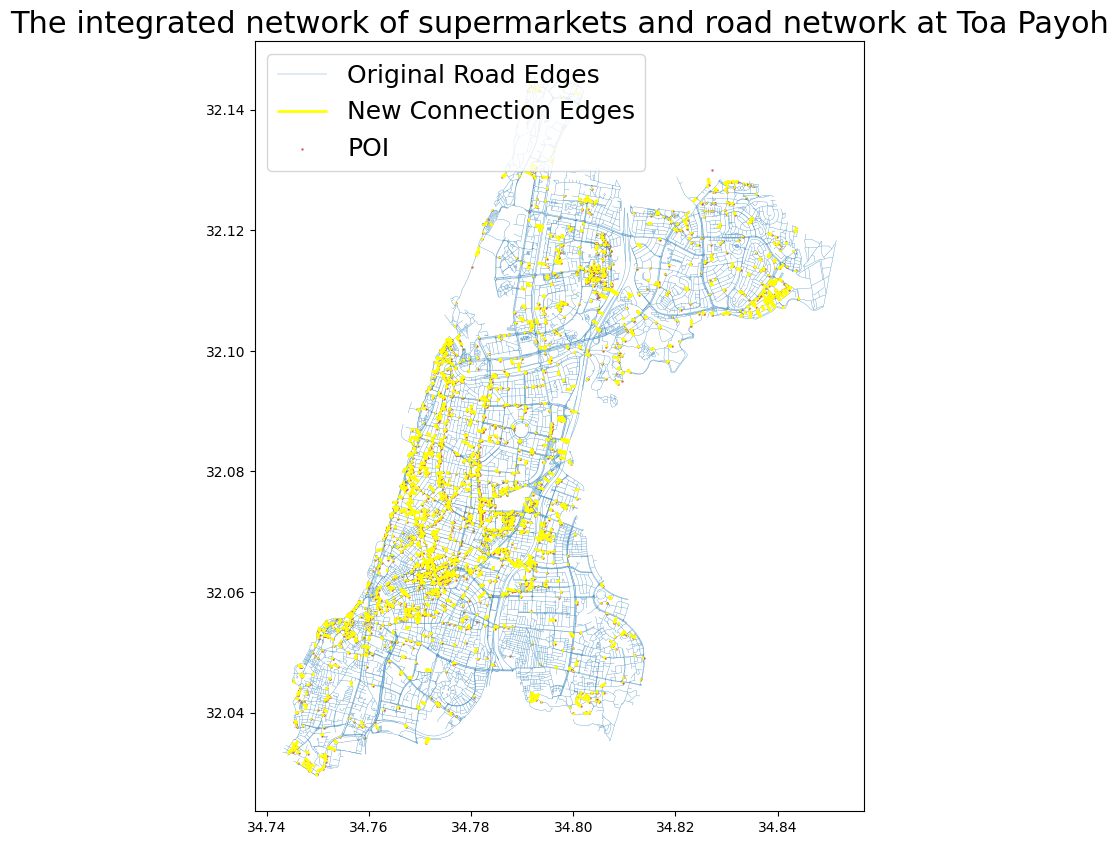

In [22]:
# output
poi_links = new_edges[new_edges['highway'] == 'projected_footway']
ax = edges.plot(linewidth=0.2, figsize=(18,10), label='Original Road Edges')
poi_links.plot(color='yellow', linewidth=2, ax=ax, label='New Connection Edges')
pois.plot(color='indianred', marker='.', markersize=2, ax=ax, label='POI')
ax.legend(loc=2, fontsize=18)
ax.set_title('The integrated network of supermarkets and road network at Toa Payoh', fontsize=22);

In [ ]:
new_edges[new_edges['from'] == 9990003122]

In [ ]:
print(pois.loc[3122]['geometry'])

In [ ]:
poi_links.loc[35770]['to']

In [ ]:
new_nodes[new_nodes['osmid'] == 9990003122]

In [ ]:
poi_links

In [ ]:
edges